In [1]:
! pip install medmnist
! pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

*This* code is based on the documentation at: https://flower.dev/docs/framework/tutorial-series-get-started-with-flower-pytorch.html & https://flower.dev/docs/framework/tutorial-series-use-a-federated-learning-strategy-pytorch.html

Imports

In [14]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
import os

import medmnist
from medmnist import INFO

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from torchvision import transforms
from torchvision.transforms import Lambda
from torch.utils.data import DataLoader
from torchvision import models

import flwr as fl
from flwr.common import Metrics

import warnings

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

At first we load the MedMNIST chest X-ray classification dataset, set the amount of participants and IID distribute the data among them. Also transform the data to three channels.

In [15]:
NUM_CLIENTS = 3
BATCH_SIZE = 32

In [16]:
def load_data():
    # preprocessing
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    data_flag = 'chestmnist'
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])
    train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
    val_set = DataClass(split='val', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
    test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)

    # Create train/val for each partition and wrap it into DataLoader
    trainloaders = []
    valloaders = []
    for partition_id in range(NUM_CLIENTS):
        partition = int(len(train_set) / NUM_CLIENTS)
        indices = list(range(partition_id * partition, (partition_id + 1) * partition))
        train_set_partition = torch.utils.data.Subset(train_set, indices)
        trainloader = DataLoader(train_set_partition, batch_size=BATCH_SIZE, shuffle=True)
        trainloaders.append(trainloader)

        partition_val = int(len(val_set) / NUM_CLIENTS)
        indices_val = list(range(partition_id * partition_val, (partition_id + 1) * partition_val))
        val_set_partition = torch.utils.data.Subset(val_set, indices_val)
        valloader = DataLoader(val_set_partition, batch_size=BATCH_SIZE, shuffle=True)
        valloaders.append(valloader)
    testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
    print("Train set size: ", len(train_set))
    print("Partitioned train set size: ", len(train_set_partition))
    print("Validation set size: ", len(val_set))
    print("Partitioned validation set size: ", len(val_set_partition))
    print("Test set size: ", len(test_set))

    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_data()

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Train set size:  78468
Partitioned train set size:  26156
Validation set size:  11219
Partitioned validation set size:  3739
Test set size:  22433


Visualize all classes in the first trainloader partition

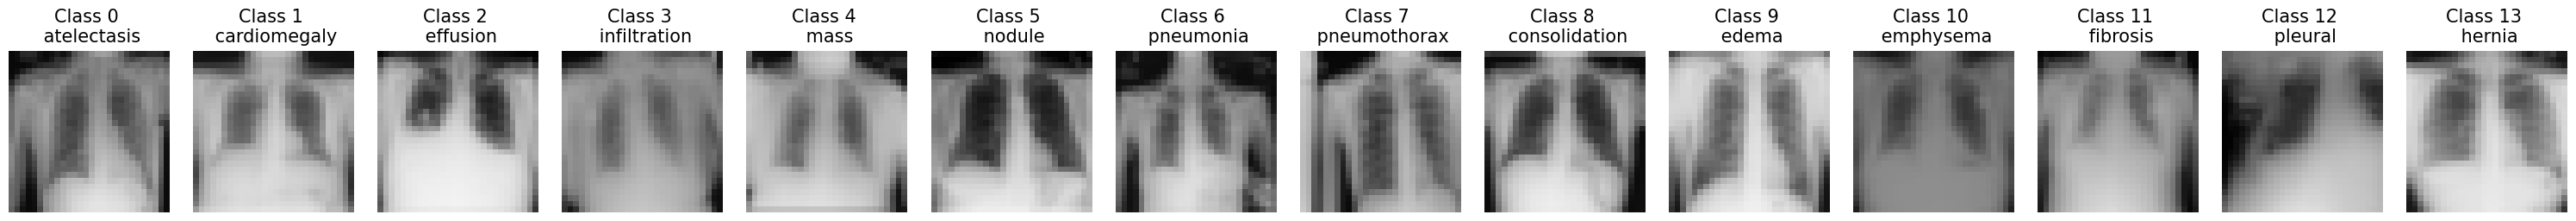

In [17]:
batch = next(iter(trainloaders[0]))
images, labels = batch
# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5
images = np.clip(images, 0, 1)
data_flag = 'chestmnist'
info = INFO[data_flag]

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 14, figsize=(30, 30))

# Loop over the images and plot them
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap="gray")
    ax.text(0.5, 1.15, f"Class {i} \n {info['label'][str(i)]}", ha='center', va='center', transform=ax.transAxes, fontsize=15)

    ax.axis('off')

# Show the plot
fig.tight_layout()
plt.show()

You are free to utilise any open-source framework for FL. Some recommendations from our side
include Flower

In [18]:
model = models.resnet18(pretrained=False)
LEARNING_RATE = 0.001

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [19]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch
            images, labels = images.to(DEVICE), labels.to(DEVICE).long()
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
    return epoch_loss, epoch_acc


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch
            images, labels = images.to(DEVICE), labels.to(DEVICE).long()
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

Train the model for 1 epoch to see if the training process works.

In [20]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = model.to(DEVICE)

for epoch in range(1):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.009907186266476218, accuracy 0.9042524739235089
Final test set performance:
	loss 0.011162417796528228
	accuracy 0.8921232113404359


In [21]:
model = models.resnet18(pretrained=False)
LEARNING_RATE = 0.001

In [22]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=False)

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader, client_metrics):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.client_metrics = client_metrics

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        set_parameters(self.net, parameters)
        train_loss, train_acc = train(self.net, self.trainloader, epochs=local_epochs)
        self.client_metrics["train_loss"].append(train_loss)
        self.client_metrics["train_accuracy"].append(train_acc)
        print(f"Client {self.cid} test loss: {train_loss}, test accuracy: {train_acc}, round {server_round}] fit, config: {config}")
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        self.client_metrics["test_loss"].append(loss)
        self.client_metrics["test_accuracy"].append(accuracy)
        print(f"Client {self.cid} test loss: {loss}, test accuracy: {accuracy},  evaluate, config: {config}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [23]:
def client_fn(cid) -> FlowerClient:
    net = model.to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    client_metrics = {
        "train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": [],
    }

    return FlowerClient(cid, net, trainloader, valloader, client_metrics)

In [24]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 if server_round < 1 else 2,  #
    }
    return config

In [25]:
# Check for available GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")

# Check for available CPUs
num_cpus = os.cpu_count()
print(f"Number of available CPUs: {num_cpus}")

Number of available GPUs: 1
Number of available CPUs: 2


The code below creates a FedAvg strategy with parameters set to ensure synchronous updates from all three clients.
The `fraction_fit` and `fraction_evaluate` parameters are set to 1, meaning all available clients are selected for
each round of training and evaluation. The `min_fit_clients`, `min_evaluate_clients`, and `min_available_clients`
parameters are set to 3, ensuring that all 3 clients are required for the training and evaluation processes.

In [26]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
# we have three clients, so we need to create three Flower clients
params = get_parameters(model)

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit = 1,
    fraction_evaluate = 1,
    min_fit_clients = 3,
    min_evaluate_clients=3,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    on_fit_config_fn=fit_config,  # Pass the fit_config function
)

# Specify the resources each of your clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are sharing the GPU among the clients.
    client_resources = {"num_cpus": 0.6, "num_gpus": 0.3}
    #client_resources = {"num_cpus": float(f"{(num_cpus / NUM_CLIENTS):.1f}"), "num_gpus": float(f"{(num_gpus / NUM_CLIENTS):.1f}")}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2024-01-22 17:21:02,486 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-01-22 17:21:08,310	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-22 17:21:10,392 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'memory': 7662138164.0, 'object_store_memory': 3831069081.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'memory': 7662138164.0, 'object_store_memory': 3831069081.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2024-01-22 17:21:10,399 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
